TIME SERIES GAN

Mount the Google Drive and Use as Storage space for Data and Later, Outputs of the Model, Images and Trained Models

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


##IMPORT MODULES AND LIBRARIES##


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tqdm import tqdm
from pathlib import PurePath
import pandas as pd
import librosa, librosa.display
import matplotlib.pyplot as plt
import numpy as np
import os
import math
import json
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from pathlib import Path
import soundfile as sf
import IPython.display as ipd
import soundfile as sf
from scipy.io import wavfile


from tensorflow.keras import layers, models, datasets, callbacks, utils, metrics, optimizers
import tensorflow.keras.backend as K
from tensorflow.keras.losses import BinaryCrossentropy, MeanSquaredError
from tensorflow.keras.utils import plot_model


***TEST IF CPU OR GPU IS USED***

In [ ]:
gpu_devices = tf.config.experimental.list_physical_devices('GPU')
if gpu_devices:
  print('Using GPU')
  # Increase memory allocation
  tf.config.experimental.set_memory_growth(tf.config.list_physical_devices('GPU')[0], True)


else:
  print('Using CPU')

Using GPU



##PREPARE DATASET##

###DATA PREPROCESSING###

PARAMETER

In [ ]:
BATCH_SIZE = 1
DATASET_PATH = 'drive/MyDrive/Capstone_Project_Data/Sound_Drum'  ##Path to the Wav File Dataset##

The **sort_audio_file_by_channels(folder_path)** is used in case the dataset folder has many files and it has to sorted by **Mono Channel** and **Multi Channel** Audio. In this Project we are using Multi Channel Drum Audio to Train the model.

In [ ]:
def sort_audio_files_by_channels(folder_path):
    # List all files in the folder
    files = [f for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f))]

    # Separate mono and multichannel files
    mono_files = []
    multichannel_files = []

    for file_name in files:
        file_path = os.path.join(folder_path, file_name)

        # Check the number of channels using librosa
        signal,_ = librosa.load(file_path, mono=False)
#         print(signal.shape)

        if len(signal.shape) > 1:
            multichannel_files.append(file_name)

        else:
            mono_files.append(file_name)


    return mono_files, multichannel_files


In [ ]:
monofiles, multichannel_files = sort_audio_files_by_channels(DATASET_PATH)
print("Number of Mono Channel Files are :{}\n".format(len(monofiles)))
print("Number of Multi Channel Files are :{}\n".format(len(multichannel_files)))

The Function **convert_to_fixed_size(dataset_path, target_duration, multichannel_files)** is used the convert all the d

In [ ]:
def convert_to_fixed_size(dataset_path,  target_duration, multichannel_files):
    for i, (dirpath, dirname, filenames) in enumerate(os.walk(dataset_path)):

        #ensure that we're not at the root level
        if dirpath is not dataset_path:
            #Get the Semantic Label
            dirpath_components = dirpath.split("\\")
            sematic_label = dirpath_components[-1]

            for f in multichannel_files:
                input_file = os.path.join(dirpath, f)
                output_folder = os.path.dirname(dataset_path) +'/fixed'

                if not os.path.exists(output_folder):
                    os.makedirs(output_folder)

                output_file = f
                # Load the audio file
                y, sr = librosa.load(input_file, mono=False, sr=None)
#                 print(len(y[0]))

                target_samples = int(sr*target_duration)

                if len(y[0]) > target_samples:
                    y_fixed_length = y[:, :target_samples]
                else:
                    pad_length = target_samples - len(y[0])
                    y_fixed_length = np.pad(y, ((0,0),(0, pad_length)), 'constant')
#                 print("{} : {}\n".format(type(y_fixed_length), y_fixed_length.shape))
                y_fixed_length = y_fixed_length.T

                sf.write(output_file, y_fixed_length, sr )


In [ ]:
with open('drive/MyDrive/Capstone_Project_Data/Train_Meta_File.txt', 'r') as file:
  data = file.read().replace('\n', '')
  files_list = data.split(',')

print(files_list)
print(len(files_list))

['056514_drum-40118.wav']
1


In [ ]:
train_data = np.load('drive/MyDrive/Capstone_Project_Data/stft_data_drums.npz')
X_train = []
for file in files_list:
  X_train.append(train_data[file])

X_train = np.asarray(X_train)
X_train = np.abs(X_train)
X_train.shape

(1, 430, 129, 2)

In [ ]:
X_train = X_train[:, :100, :128, :]
print(X_train.shape)
audio = librosa.istft(X_train[0].T)
ipd.Audio(audio, rate=11000)

(1, 100, 128, 2)


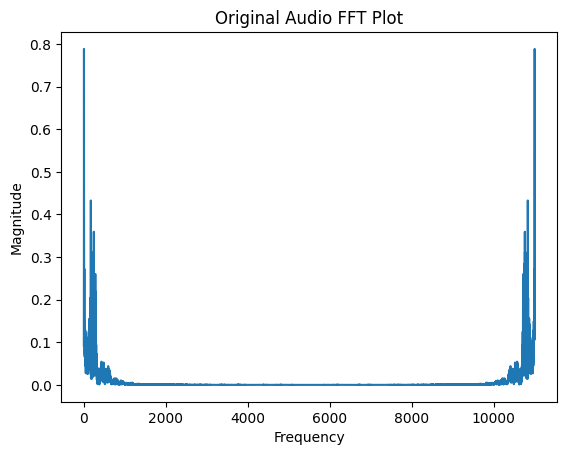

In [ ]:
fft = np.fft.fft(audio[1])
magnitude = np.abs(fft)
frequency = np.linspace(0, 11000, len(magnitude))
plt.plot(frequency, magnitude)
plt.xlabel("Frequency")
plt.ylabel("Magnitude")
plt.title('Original Audio FFT Plot')
plt.savefig("fft_original.png")
plt.show()

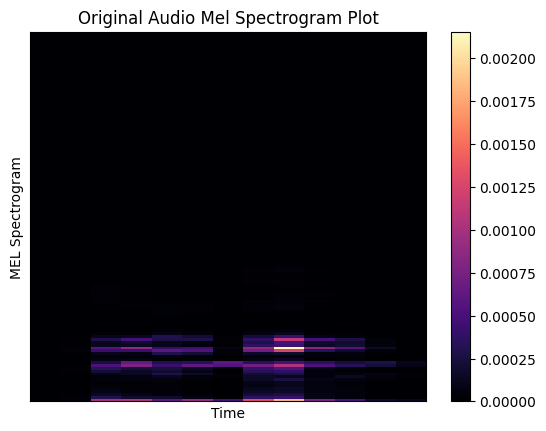

In [ ]:
#MFCC
MFCCs = librosa.feature.melspectrogram(y=audio[1], n_fft=2048, hop_length=512, n_mels=128)
# librosa.display.specshow(MFCCs, sr=sr, hop_length=hop_length)
librosa.display.specshow(MFCCs, sr=11000, hop_length=512)
plt.xlabel("Time")
plt.ylabel("MEL Spectrogram")
plt.title('Original Audio Mel Spectrogram Plot')
plt.colorbar()
plt.savefig('melspectrogram_original.png')
plt.show()

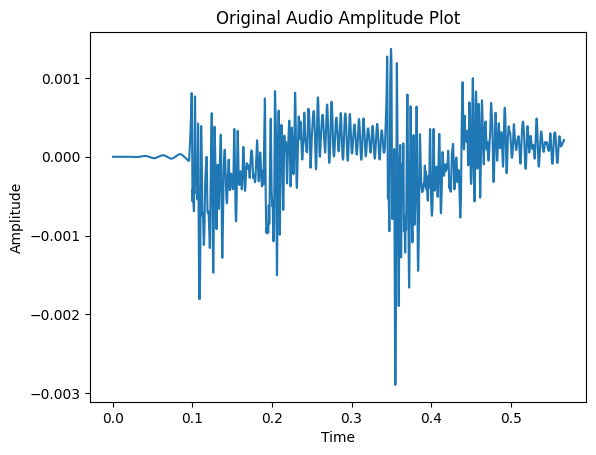

In [ ]:
time = np.linspace(0, len(audio[1])/11000, num=len(audio[1]))
plt.plot(time, audio[1])
plt.xlabel("Time")
plt.ylabel("Amplitude")
plt.title('Original Audio Amplitude Plot')
plt.savefig("original_audio_waveplot.png")
plt.show()

In [ ]:
real_series = (tf.data.Dataset.from_tensor_slices(X_train)
                .batch(BATCH_SIZE, drop_remainder=True))
real_series_iter = iter(real_series.repeat())

In [ ]:
EMBEDDING_DIM = 100
X_DIM = 100
Y_DIM = 128
Z_DIM = 2
FEATURES = 2


In [ ]:
def make_random_data():
  while True:
    yield np.random.uniform(low=0, high=1, size=(X_DIM,Y_DIM,Z_DIM))

In [ ]:
random_dataset = (tf.data.Dataset.from_generator(make_random_data, output_types=tf.float32, output_shapes=(X_DIM,Y_DIM,Z_DIM))
                      .batch(BATCH_SIZE)
                      .repeat())

In [ ]:
random_series = iter(random_dataset)

In [ ]:
random_dataset

<_RepeatDataset element_spec=TensorSpec(shape=(None, 100, 128, 2), dtype=tf.float32, name=None)>

###SETUP LOGGER###

In [ ]:
results_path = Path('TimeGAN')
if not results_path.exists():
  results_path.mkdir()

In [ ]:
experiments = 0

In [ ]:
log_dir = results_path / f'experiment_{experiments:02}'
if not log_dir.exists():
  log_dir.mkdir(parents=True)

In [ ]:
writer = tf.summary.create_file_writer(log_dir.as_posix())

**EMBEDDER NETWORK**

In [ ]:
#Embedder
embedder_input = layers.Input(shape=(X_DIM, Y_DIM, Z_DIM), name="RealData")   ## Image Size height, width, channels

e = layers.Conv2D(16, kernel_size=3, strides=2, padding="same", name="Embedder_Conv2D_Layer1")(embedder_input)
e = layers.LeakyReLU(0.2)(e)
e = layers.Conv2D(8, kernel_size=3, strides=2, padding="same", name="Embedder_Conv2D_Layer2")(e)
e = layers.LeakyReLU()(e)
e = layers.Dropout(0.3)(e)
e = layers.Conv2D(8, kernel_size=3, strides=1, padding="same", name="Embedder_Conv2D_Layer3")(e)
e = layers.LeakyReLU(0.2)(e)
e = layers.Dropout(0.3)(e)
e = layers.Conv2D(8, kernel_size=3, strides=1, padding="same", name="Embedder_Conv2D_Layer4")(e)
e = layers.LeakyReLU(0.2)(e)
shape_before_flattening = K.int_shape(e)[1:]
print("SHAPE BEFORE FLATTENING THE EMBEDDER NETWORK {}".format(shape_before_flattening))
e = layers.Flatten()(e)
embedder_output = layers.Dense(EMBEDDING_DIM*128, name = "Embedder_Output")(e)
embedder_output = layers.Reshape(target_shape=(X_DIM, Y_DIM))(embedder_output)
embedder = tf.keras.Model(embedder_input, embedder_output)

# embedder = models.Model([embedder_input, label_input], embedder_ouput)

print("EMBEDDER NETWORK LOOKS LIKE : \n")
embedder.summary()



SHAPE BEFORE FLATTENING THE EMBEDDER NETWORK (25, 32, 8)
EMBEDDER NETWORK LOOKS LIKE : 

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 RealData (InputLayer)       [(None, 100, 128, 2)]     0         
                                                                 
 Embedder_Conv2D_Layer1 (Co  (None, 50, 64, 16)        304       
 nv2D)                                                           
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 50, 64, 16)        0         
                                                                 
 Embedder_Conv2D_Layer2 (Co  (None, 25, 32, 8)         1160      
 nv2D)                                                           
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 25, 32, 8)         0         
                                      

**RECOVERY NETWORK**

In [ ]:
#Recovery
recovery_input = layers.Input(shape=(EMBEDDING_DIM,128), name="Recovery_Input")

r = layers.Flatten()(recovery_input)
r = layers.Dense(np.prod(shape_before_flattening))(r)
r = layers.Reshape(shape_before_flattening)(r)
r = layers.Conv2DTranspose(16, kernel_size=3, strides=1, padding="same", use_bias=False, name="Recovery_Conv2DT_Layer1")(r)
r = layers.BatchNormalization(momentum=0.9)(r)
r = layers.LeakyReLU(0.2)(r)
r = layers.Conv2DTranspose(8, kernel_size=3, strides=2, padding="same", use_bias=False, name="Recovery_Conv2DT_Layer2")(r)
r = layers.BatchNormalization(momentum=0.9)(r)
r = layers.LeakyReLU(0.2)(r)
r = layers.Conv2DTranspose(8, kernel_size=3, strides=2, padding="same", use_bias=False, name="Embedder_Conv2DT_Layer3")(r)
r = layers.BatchNormalization(momentum=0.9)(r)
r = layers.LeakyReLU(0.2)(r)
r = layers.Conv2DTranspose(8, kernel_size=2, strides=1, padding="same", use_bias=False, name="Embedder_Conv2DT_Layer4")(r)
r = layers.BatchNormalization(momentum=0.9)(r)
r = layers.LeakyReLU(0.2)(r)
recovery_output = layers.Conv2DTranspose(2, kernel_size=3, strides=1, padding="same", activation="tanh", name="Embedder_Conv2DT_Layer5")(r)

# recovery = models.Model([recovery_input, label_input], recovery_output)
recovery = tf.keras.Model(recovery_input, recovery_output)
print("RECOVERY NETWORK LOOKS LIKE: \n")
recovery.summary()


RECOVERY NETWORK LOOKS LIKE: 

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Recovery_Input (InputLayer  [(None, 100, 128)]        0         
 )                                                               
                                                                 
 flatten_1 (Flatten)         (None, 12800)             0         
                                                                 
 dense (Dense)               (None, 6400)              81926400  
                                                                 
 reshape_1 (Reshape)         (None, 25, 32, 8)         0         
                                                                 
 Recovery_Conv2DT_Layer1 (C  (None, 25, 32, 16)        1152      
 onv2DTranspose)                                                 
                                                                 
 batch_normalization (Batch 

**GENERATOR NETWORK**

In [ ]:
#Generator
generator_input = layers.Input(shape=(X_DIM, Y_DIM, Z_DIM), name="Random_Input")

g = layers.Conv2D(16, kernel_size=3, strides=2, padding="same", name="Generator_Conv2D_Layer1")(generator_input)
g = layers.LeakyReLU(0.2)(g)
g = layers.Conv2D(8, kernel_size=3, strides=2, padding="same", name="Generator_Conv2D_Layer2")(g)
g = layers.LeakyReLU()(g)
g = layers.Dropout(0.3)(g)
g = layers.Conv2D(8, kernel_size=3, strides=2, padding="same", name="Generator_Conv2D_Layer3")(g)
g = layers.LeakyReLU(0.2)(g)
g = layers.Dropout(0.3)(g)
g = layers.Conv2D(8, kernel_size=3, strides=2, padding="same", name="Generator_Conv2D_Layer4")(g)
g = layers.LeakyReLU(0.2)(g)
g = layers.Flatten()(g)
generator_output = layers.Dense(EMBEDDING_DIM*128, name = "Generator_Output")(g)
generator_output = layers.Reshape(target_shape=(X_DIM, Y_DIM))(generator_output)

# generator = models.Model([generator_input, label_input], generator_ouput)
generator = tf.keras.Model(generator_input, generator_output)

print("EMBEDDER NETWORK LOOKS LIKE : \n")
generator.summary()

EMBEDDER NETWORK LOOKS LIKE : 

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Random_Input (InputLayer)   [(None, 100, 128, 2)]     0         
                                                                 
 Generator_Conv2D_Layer1 (C  (None, 50, 64, 16)        304       
 onv2D)                                                          
                                                                 
 leaky_re_lu_8 (LeakyReLU)   (None, 50, 64, 16)        0         
                                                                 
 Generator_Conv2D_Layer2 (C  (None, 25, 32, 8)         1160      
 onv2D)                                                          
                                                                 
 leaky_re_lu_9 (LeakyReLU)   (None, 25, 32, 8)         0         
                                                                 
 dropout_2 (Dropout)       

**SUPERVISOR**

In [ ]:
#Supervisor
supervisor_input = layers.Input(shape=(EMBEDDING_DIM,128), name="Supervisor_Input")
s = layers.Conv1D(16,kernel_size=3, strides=1, padding="same",  name="Supervisor_Dense_Layer1")(supervisor_input)
s = layers.LeakyReLU(0.2)(s)
s = layers.Conv1D(8, kernel_size=3, strides=1, padding="same", name="Supervisor_Dense_Layer2")(s)
s = layers.LeakyReLU()(s)
s = layers.Dropout(0.3)(s)

s = layers.Conv1D(8, kernel_size=3, strides=1, padding="same", name="Supervisor_Dense_Layer3")(s)
s = layers.LeakyReLU(0.2)(s)
s = layers.Dropout(0.3)(s)
s = layers.Conv1D(8, kernel_size=3, strides=1, padding="same", name="Supervisor_Dense_Layer4")(s)
s = layers.LeakyReLU(0.2)(s)

s = layers.Flatten()(s)
supervisor_output = layers.Dense(EMBEDDING_DIM*128, name = "Supervisor_Output")(s)
supervisor_output = layers.Reshape(target_shape=(X_DIM,Y_DIM))(supervisor_output)

# supervisor = models.Model([supervisor_input, label_input], supervisor_ouput)
supervisor = tf.keras.Model(supervisor_input, supervisor_output)

print("SUPERVISOR NETWORK LOOKS LIKE : \n")
supervisor.summary()



SUPERVISOR NETWORK LOOKS LIKE : 

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Supervisor_Input (InputLay  [(None, 100, 128)]        0         
 er)                                                             
                                                                 
 Supervisor_Dense_Layer1 (C  (None, 100, 16)           6160      
 onv1D)                                                          
                                                                 
 leaky_re_lu_12 (LeakyReLU)  (None, 100, 16)           0         
                                                                 
 Supervisor_Dense_Layer2 (C  (None, 100, 8)            392       
 onv1D)                                                          
                                                                 
 leaky_re_lu_13 (LeakyReLU)  (None, 100, 8)            0         
                         

**DISCRIMINATOR**

In [ ]:
#Discriminator
discriminator_input = layers.Input(shape=(EMBEDDING_DIM,128), name="Discriminator_Input")
# label_input = layers.Input(shape=(15,))
# d = layers.Concatenate(axis=-1)([discriminator_input, label_input])
d = layers.Flatten()(discriminator_input)
d = layers.Dense(np.prod(shape_before_flattening))(d)
d = layers.Reshape(shape_before_flattening)(d)
d = layers.Conv2D(8, kernel_size=3, strides=1, padding="same", use_bias=False, name="Discriminator_Conv2D_Layer1")(d)
d = layers.BatchNormalization(momentum=0.9)(d)
d = layers.LeakyReLU(0.2)(d)
d = layers.Conv2D(8, kernel_size=3, strides=2, padding="same", use_bias=False, name="Discriminator_Conv2D_Layer2")(d)
d = layers.BatchNormalization(momentum=0.9)(d)
d = layers.LeakyReLU(0.2)(d)
d = layers.Conv2D(8, kernel_size=3, strides=2, padding="same", use_bias=False, name="Discriminator_Conv2D_Layer3")(d)
d = layers.BatchNormalization(momentum=0.9)(d)
d = layers.LeakyReLU(0.2)(d)
# d = layers.Conv2D(8, kernel_size=3, strides=2, padding="same", use_bias=False, name="Discriminator_Conv2D_Layer4")(d)
# d = layers.BatchNormalization(momentum=0.9)(d)
# d = layers.LeakyReLU(0.2)(d)
d = layers.Flatten()(d)
discriminator_output = layers.Dense(1, activation="sigmoid", name="Discriminator_Output")(d)

# discriminator = models.Model([discriminator_input, label_input], discriminator_output)
discriminator = tf.keras.Model(discriminator_input, discriminator_output)
print("DISCRIMINATOR NETWORK LOOKS LIKE: \n")
discriminator.summary()


DISCRIMINATOR NETWORK LOOKS LIKE: 

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Discriminator_Input (Input  [(None, 100, 128)]        0         
 Layer)                                                          
                                                                 
 flatten_6 (Flatten)         (None, 12800)             0         
                                                                 
 dense_2 (Dense)             (None, 6400)              81926400  
                                                                 
 reshape_5 (Reshape)         (None, 25, 32, 8)         0         
                                                                 
 Discriminator_Conv2D_Layer  (None, 25, 32, 8)         576       
 1 (Conv2D)                                                      
                                                                 
 batch_normalization_7 

#TIMEGAN TRAINING#


###SETTINGS###

In [ ]:
TRAINSTEPS = 10000
GAMMA = 1

##GENERIC LOSS FUNCTION ##

We define two generic loss functions, namel MeanSquaredError and BinaryCrossEntropy that will be used later to create the various specific loss

In [ ]:
mse = MeanSquaredError()
bce = BinaryCrossentropy()

In [ ]:
H = embedder(embedder_input)
X_tilde = recovery(H)
autoencoder = models.Model(inputs=embedder_input, outputs=X_tilde, name='AutoEncoder')

In [ ]:
autoencoder.summary()

Model: "AutoEncoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 RealData (InputLayer)       [(None, 100, 128, 2)]     0         
                                                                 
 model (Functional)          (None, 100, 128)          81935432  
                                                                 
 model_1 (Functional)        (None, 100, 128, 2)       81929842  
                                                                 
Total params: 163865274 (625.10 MB)
Trainable params: 163865194 (625.10 MB)
Non-trainable params: 80 (320.00 Byte)
_________________________________________________________________


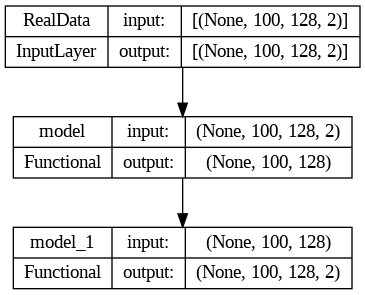

In [ ]:
plot_model(autoencoder, to_file=(results_path / 'autoencoder.png').as_posix(), show_shapes=True)

**AUTOENCODER OPTIMIZER**

In [ ]:
autoencoder_optimizer = optimizers.Adam(learning_rate=0.0005)

#AUTOENCODER TRAINING LOOP#
The reconstruction loss simply compares the autoencoder outputs with its inputs. We train for train_steps in a little over one minute using this training loop that records the step loss for monitoring with TensorBoard

In [ ]:
#AUTO ENCODER TRAINING STEP
@tf.function
def train_autoencoder_init(x):
  with tf.GradientTape() as tape:
    x_tilde = autoencoder(x)
    embedding_loss_t0 = mse(x, x_tilde)
    e_loss_0 = 10 * tf.sqrt(embedding_loss_t0)

  var_list = embedder.trainable_variables + recovery.trainable_variables
  gradients = tape.gradient(e_loss_0, var_list)
  autoencoder_optimizer.apply_gradients(zip(gradients, var_list))
  return tf.sqrt(embedding_loss_t0)

In [ ]:
for step in tqdm(range(TRAINSTEPS)):
  X_ = next(real_series_iter)    ##TODO: Create tf.data.Dataset in real_series_iter.
  step_e_loss_t0 = train_autoencoder_init(X_)
  with writer.as_default():     ##TODO: Set up logger tf.summary.create_file_writer(log_dir.as_posix())
    tf.summary.scalar('Loss Autoencoder Init', step_e_loss_t0, step=step)
  if step % 1000 == 0:
    autoencoder.save('autoencoder_{}.keras'.format(step))

100%|██████████| 10000/10000 [03:07<00:00, 53.27it/s]


##PERSIST MODEL##

In [ ]:
autoencoder.save(log_dir/ 'autoencoder.keras')
autoencoder.save(log_dir/ 'autoencoder.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


#PHASE 2: SUPERVISED TRAINING #
We already created the supervisor model so we just need to instantiate the optimizer and define the train steps as follows.


##DEFINE OPTIMIZER##

In [ ]:
supervisor_optimizer = optimizers.Adam(learning_rate=0.0005)

## TRAIN STEP ##

In [ ]:
@tf.function
def train_supervisor(x):
  with tf.GradientTape() as tape:
    h = embedder(x)
    h_hat_supervised = supervisor(h)
    g_loss_s = mse(h, h_hat_supervised)

  var_list = supervisor.trainable_variables
  gradients = tape.gradient(g_loss_s, var_list)
  supervisor_optimizer.apply_gradients(zip(gradients, var_list))
  return g_loss_s

In this case, the loss compares the output of the supervisor with the next timestep for the embedded sequence so that it learns the temporal dynamics of the data; the training loop works similarly to the autoencoder

##TRAINING LOOP##

In [ ]:
for step in tqdm(range(TRAINSTEPS)):
  X_ = next(real_series_iter)
  step_g_loss_s = train_supervisor(X_)
  with writer.as_default():
    tf.summary.scalar('Loss Generator Supervised Init', step_g_loss_s, step=step)

100%|██████████| 10000/10000 [00:38<00:00, 261.23it/s]


##PRESIST MODEL##

In [ ]:
supervisor.save(log_dir/'supervisor.keras')
supervisor.save(log_dir/'supervisor.h5')

In [ ]:
# autoencoder = models.load_model('drive/MyDrive/Capstone_Project_Data/autoencoder.h5')
# supervisor = models.load_model('drive/MyDrive/Capstone_Project_Data/supervisor.h5')

OSError: ignored

#JOINT TRAINING#
The joint training involves all four network compoenents as well as the supervisor. It uses multiple loss functions and combinations of the base components to achieve the simultaneous learning of the latent space embeddings, transistion dynamics, and synthetic data generations.

##GENERATOR##

### Adversarial Architecture- Supervised ###

In [ ]:
E_hat = generator(generator_input)
H_hat = supervisor(E_hat)
Y_fake = discriminator(H_hat)

adversarial_supervised = models.Model(inputs=generator_input, outputs=Y_fake, name='AdversarialNetSupervised')
print("ADVERSARIAL NET:\n")
adversarial_supervised.summary()

ADVERSARIAL NET:

Model: "AdversarialNetSupervised"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Random_Input (InputLayer)   [(None, 100, 128, 2)]     0         
                                                                 
 model_2 (Functional)        (None, 100, 128)          5749832   
                                                                 
 model_3 (Functional)        (None, 100, 128)          10259752  
                                                                 
 model_5 (Functional)        (None, 1)                 81928673  
                                                                 
Total params: 97938257 (373.60 MB)
Trainable params: 97938209 (373.60 MB)
Non-trainable params: 48 (192.00 Byte)
_________________________________________________________________


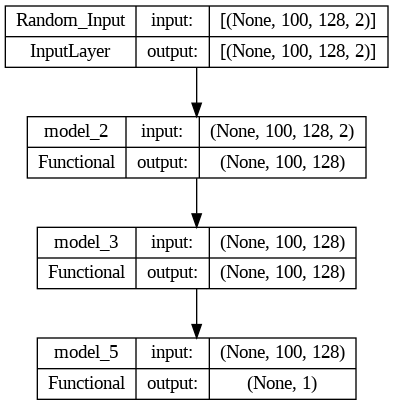

In [ ]:
plot_model(adversarial_supervised, to_file=(results_path / 'adversarial_supervised.png').as_posix(),show_shapes=True)

##ADVERSARIAL ARCHITECTURE IN LATENT SPACE ##


In [ ]:
Y_fake_e = discriminator(E_hat)

adversarial_emb = models.Model(inputs=generator_input, outputs=Y_fake_e, name="AdversarialNet")

In [ ]:
print("ADVERSARIAL EMBEDDED:\n")
adversarial_emb.summary()

ADVERSARIAL EMBEDDED:

Model: "AdversarialNet"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Random_Input (InputLayer)   [(None, 100, 128, 2)]     0         
                                                                 
 model_2 (Functional)        (None, 100, 128)          5749832   
                                                                 
 model_5 (Functional)        (None, 1)                 81928673  
                                                                 
Total params: 87678505 (334.47 MB)
Trainable params: 87678457 (334.47 MB)
Non-trainable params: 48 (192.00 Byte)
_________________________________________________________________


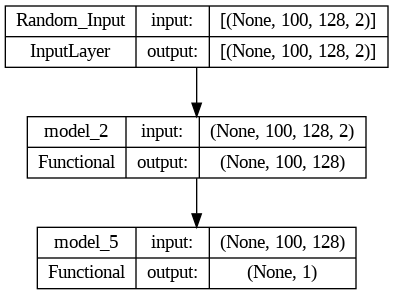

In [ ]:
plot_model(adversarial_emb, to_file=(results_path / 'adversarial_emb.png').as_posix(),show_shapes=True)

## MEAN AND VARIANCE LOSS ##

To Ensure that the generator faithfully reproduces the time series, TimeGAN includes a moment loss that penalizes when mean and variance of the synthetic data deviate from the real version

In [ ]:
X_hat = recovery(H_hat)
synthetic_data = models.Model(inputs=generator_input, outputs=X_hat, name="SyntheticData")

The end to end model that produces synthetic data involves the generator, supervisor and recovery component. It is defined as follows and has thousands of trainable pramaters

In [ ]:
synthetic_data.summary()

Model: "SyntheticData"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Random_Input (InputLayer)   [(None, 100, 128, 2)]     0         
                                                                 
 model_2 (Functional)        (None, 100, 128)          5749832   
                                                                 
 model_3 (Functional)        (None, 100, 128)          10259752  
                                                                 
 model_1 (Functional)        (None, 100, 128, 2)       81929842  
                                                                 
Total params: 97939426 (373.61 MB)
Trainable params: 97939346 (373.61 MB)
Non-trainable params: 80 (320.00 Byte)
_________________________________________________________________


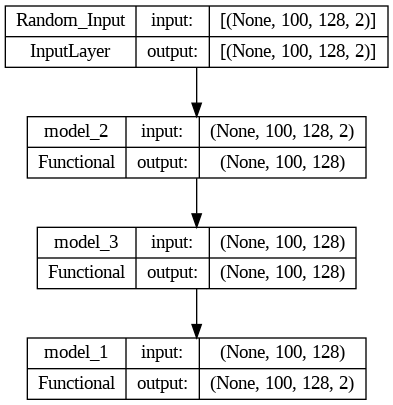

In [ ]:
plot_model(synthetic_data, to_file=(results_path / 'synthetic_data.png').as_posix(), show_shapes=True)

In [ ]:
def get_generator_moment_loss(y_true, y_pred):
  y_true_mean, y_true_var = tf.nn.moments(x=y_true, axes=[0])
  y_pred_mean, y_pred_var = tf.nn.moments(x=y_pred, axes=[0])
  g_loss_mean = tf.reduce_mean(tf.abs(y_true_mean - y_pred_mean))
  g_loss_var = tf.reduce_mean(tf.abs(tf.sqrt(y_true_var + 1e-6) - tf.sqrt(y_pred_var + 1e-6)))
  return g_loss_mean + g_loss_var

#DISCRIMINATOR#

###ARCHITECTURE: REAL DATA###

In [ ]:
Y_real = discriminator(H)
discriminator_model = models.Model(inputs=embedder_input, outputs=Y_real, name="DiscriminatorReal")

In [ ]:
discriminator_model.summary()

Model: "DiscriminatorReal"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 RealData (InputLayer)       [(None, 100, 128, 2)]     0         
                                                                 
 model (Functional)          (None, 100, 128)          81935432  
                                                                 
 model_5 (Functional)        (None, 1)                 81928673  
                                                                 
Total params: 163864105 (625.09 MB)
Trainable params: 163864057 (625.09 MB)
Non-trainable params: 48 (192.00 Byte)
_________________________________________________________________


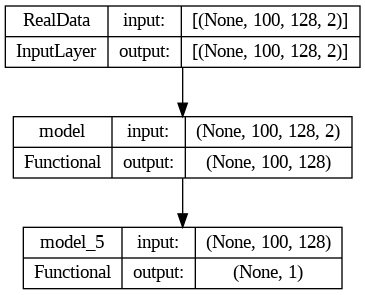

In [ ]:
plot_model(discriminator_model,to_file=(results_path / 'discriminator.png').as_posix(), show_shapes=True)

##OPTIMIZERS##

The joint training involves three optimizers for the autoencoder, the generator and the discriminator

In [ ]:
generator_optimizer=optimizers.Adam(learning_rate=0.0005)
discriminator_optimizer = optimizers.Adam(learning_rate=0.0005)
embedding_optimizer = optimizers.Adam(learning_rate=0.0005)

##GENERATOR TRAIN STEPS##

In [ ]:
@tf.function
def train_generator(x, z):
  with tf.GradientTape() as tape:
    y_fake = adversarial_supervised(z)
    generator_loss_unsupervised = bce(y_true=tf.ones_like(y_fake), y_pred=y_fake)

    y_fake_e = adversarial_emb(z)
    generator_loss_unsupervised_e = bce(y_true=tf.ones_like(y_fake_e), y_pred=y_fake_e)

    h = embedder(x)
    h_hat_supervised = supervisor(h)
    generator_loss_supervised = mse(h, h_hat_supervised)

    x_hat = synthetic_data(z)
    generator_moment_loss = get_generator_moment_loss(x, x_hat)

    generator_loss = (generator_loss_unsupervised +
                      generator_loss_unsupervised_e +
                      100 * tf.sqrt(generator_loss_supervised) +
                      100 * generator_moment_loss)

  var_list = generator.trainable_variables + supervisor.trainable_variables
  gradients = tape.gradient(generator_loss, var_list)
  generator_optimizer.apply_gradients(zip(gradients, var_list))
  return generator_loss_unsupervised, generator_loss_supervised, generator_moment_loss

##EMBEDDING TRAINING STEP##

In [ ]:
@tf.function
def train_embedder(x):
  with tf.GradientTape() as tape:
    h = embedder(x)
    h_hat_supervised = supervisor(h)
    generator_loss_supervised = mse(h, h_hat_supervised)

    x_tilde = autoencoder(x)
    embedding_loss_t0 = mse(x, x_tilde)
    e_loss = 10 * tf.sqrt(embedding_loss_t0) + 0.1*generator_loss_supervised

  var_list = embedder.trainable_variables + recovery.trainable_variables
  gradients = tape.gradient(e_loss, var_list)
  embedding_optimizer.apply_gradients(zip(gradients, var_list))
  return tf.sqrt(embedding_loss_t0)

##DISCRIMINATOR TRAIN STEP##


In [ ]:
@tf.function
def get_discriminator_loss(x, z):
  y_real = discriminator_model(x)
  discriminator_loss_real = bce(y_true = tf.ones_like(y_real), y_pred=y_real)

  y_fake = adversarial_supervised(z)
  discriminator_loss_fake = bce(y_true=tf.zeros_like(y_fake), y_pred=y_fake)

  y_fake_e = adversarial_emb(z)
  discriminator_loss_fake_e = bce(y_true=tf.zeros_like(y_fake_e), y_pred=y_fake_e)

  return(discriminator_loss_real + discriminator_loss_fake + GAMMA*discriminator_loss_fake_e)

In [ ]:
@tf.function
def train_discriminator(x, z):
  with tf.GradientTape() as tape:
    discriminator_loss = get_discriminator_loss(x, z)

    var_list = discriminator.trainable_variables
    gradients = tape.gradient(discriminator_loss, var_list)
    discriminator_optimizer.apply_gradients(zip(gradients, var_list))
    return discriminator_loss

##TRAINING LOOP##

In [ ]:
step_g_loss_u = step_g_loss_s = step_g_loss_v = step_e_loss_t0 = step_d_loss = 0
for step in range(TRAINSTEPS):
    # Train generator (twice as often as discriminator)
    for kk in range(2):
        X_ = next(real_series_iter)
        Z_ = next(random_series)

        # Train generator
        step_g_loss_u, step_g_loss_s, step_g_loss_v = train_generator(X_, Z_)
        # Train embedder
        step_e_loss_t0 = train_embedder(X_)

    X_ = next(real_series_iter)
    Z_ = next(random_series)
    step_d_loss = get_discriminator_loss(X_, Z_)
    if step_d_loss > 0.15:
        step_d_loss = train_discriminator(X_, Z_)

    if step % 1000 == 0:
        print('{:6,.0f} | d_loss: {:6.4f} | g_loss_u: {:6.4f} | g_loss_s: {:6.4f} | g_loss_v: {:6.4f} | e_loss_t0: {:6.4f}'.format(step, step_d_loss, step_g_loss_u, step_g_loss_s, step_g_loss_v, step_e_loss_t0))

    with writer.as_default():
        tf.summary.scalar('G Loss S', step_g_loss_s, step=step)
        tf.summary.scalar('G Loss U', step_g_loss_u, step=step)
        tf.summary.scalar('G Loss V', step_g_loss_v, step=step)
        tf.summary.scalar('E Loss T0', step_e_loss_t0, step=step)
        tf.summary.scalar('D Loss', step_d_loss, step=step)

     0 | d_loss: 2.4002 | g_loss_u: 0.6391 | g_loss_s: 0.0002 | g_loss_v: 0.0054 | e_loss_t0: 0.0248
 1,000 | d_loss: 1.9271 | g_loss_u: 1.1217 | g_loss_s: 0.0000 | g_loss_v: 0.0006 | e_loss_t0: 0.0013
 2,000 | d_loss: 1.9243 | g_loss_u: 1.0506 | g_loss_s: 0.0000 | g_loss_v: 0.0007 | e_loss_t0: 0.0011
 3,000 | d_loss: 1.9313 | g_loss_u: 1.0712 | g_loss_s: 0.0000 | g_loss_v: 0.0007 | e_loss_t0: 0.0010
 4,000 | d_loss: 1.9186 | g_loss_u: 1.0950 | g_loss_s: 0.0000 | g_loss_v: 0.0006 | e_loss_t0: 0.0009
 5,000 | d_loss: 1.9095 | g_loss_u: 1.1159 | g_loss_s: 0.0000 | g_loss_v: 0.0006 | e_loss_t0: 0.0009
 6,000 | d_loss: 1.9088 | g_loss_u: 1.0802 | g_loss_s: 0.0000 | g_loss_v: 0.0006 | e_loss_t0: 0.0008
 7,000 | d_loss: 1.9110 | g_loss_u: 1.0869 | g_loss_s: 0.0000 | g_loss_v: 0.0005 | e_loss_t0: 0.0008
 8,000 | d_loss: 1.9088 | g_loss_u: 1.0849 | g_loss_s: 0.0000 | g_loss_v: 0.0005 | e_loss_t0: 0.0007
 9,000 | d_loss: 1.9084 | g_loss_u: 1.0961 | g_loss_s: 0.0000 | g_loss_v: 0.0005 | e_loss_t

In [ ]:
synthetic_data.save(log_dir /'synthetic_data.keras')
synthetic_data.save(log_dir/'synthetic_data.h5')

#GENERATE SYNTHETIC DATA#

In [ ]:
generated_data = []
for i in range(20):
    Z_ = next(random_series)
    d = synthetic_data(Z_)
    generated_data.append(d)

In [ ]:
len(generated_data)

20

In [ ]:
generated_data = np.array(np.vstack(generated_data))
generated_data.shape

(20, 100, 128, 2)

In [ ]:
np.save(log_dir / 'generated_data_drum_v4.npy', generated_data)

##MEL SPECTROGRAM INVERSE TRANSFORM##

In [ ]:
sample_audio = generated_data[1].T
sample_audio.shape

(2, 128, 100)

In [ ]:
generated_audio = librosa.istft(sample_audio)
ipd.Audio(generated_audio, rate=11000)


In [ ]:
!pip install pydub

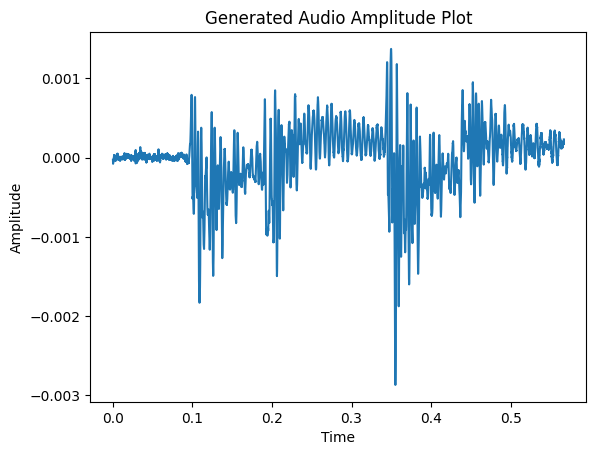

In [ ]:
Time = np.linspace(0, len(generated_audio[1])/11000, num=len(generated_audio[1]))
plt.plot(Time, generated_audio[1])
plt.xlabel("Time")
plt.ylabel("Amplitude")
plt.title("Generated Audio Amplitude Plot")
plt.savefig("generated_audio_waveplot.png")
plt.show()

In [ ]:
print(generated_audio.shape)
mono_generated_audio = generated_audio[1]
print(mono_generated_audio.shape)

(2, 6237)
(6237,)


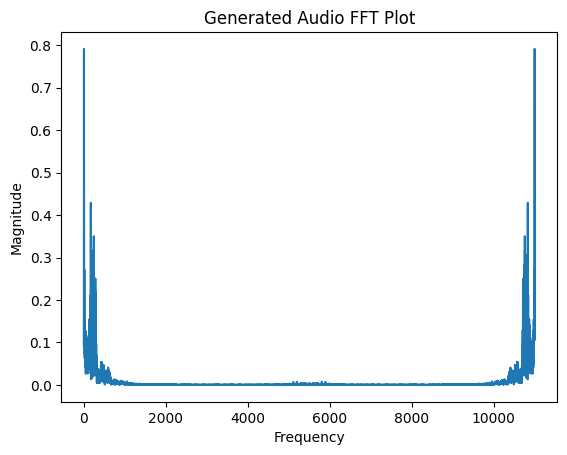

In [ ]:

fft = np.fft.fft(mono_generated_audio)
magnitude = np.abs(fft)
frequency = np.linspace(0, 11000, len(magnitude))
plt.plot(frequency, magnitude)
plt.xlabel("Frequency")
plt.ylabel("Magnitude")
plt.title("Generated Audio FFT Plot")
plt.savefig("fft_generated.png")
plt.show()

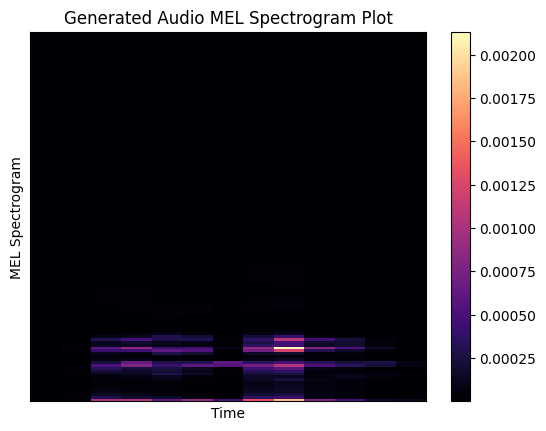

In [ ]:
#MFCC
MFCCs = librosa.feature.melspectrogram(y=mono_generated_audio, n_fft=2048, hop_length=512, n_mels=128)
# librosa.display.specshow(MFCCs, sr=sr, hop_length=hop_length)
librosa.display.specshow(MFCCs, sr=11000, hop_length=512)
plt.xlabel("Time")
plt.ylabel("MEL Spectrogram")
plt.title("Generated Audio MEL Spectrogram Plot")
plt.colorbar()
plt.savefig('melspectrogram_generated.png')
plt.show()

In [ ]:
print("Original Audio Shape is {}".format(audio.shape))
print("Generated Audio Shape is {}".format(generated_audio.shape))

Original Audio Shape is (2, 6237)
Generated Audio Shape is (2, 6237)


##AUDIO FILE GENERATION##

In [ ]:
import soundfile as sf
original_audio_signal = audio.reshape(-1, 2).T
generated_audio_signal = generated_audio.reshape(-1, 2).T
generated_audio_signal = generated_audio_signal*90
original_audio_signal = original_audio_signal*90
sf.write("generated_audio_output.wav", generated_audio_signal.T, samplerate=11000)
print(np.max(generated_audio_signal.T))

0.12329818


In [ ]:
sf.write("original_audio_output.wav", original_audio_signal.T, samplerate=11000)

In [ ]:
from pydub import AudioSegment
AudioSegment.from_wav("generated_audio_output.wav").export("generated_audio_output.mp3", format="mp3")
AudioSegment.from_wav("original_audio_output.wav").export("original_audio_output.mp3", format="mp3")


<_io.BufferedRandom name='original_audio_output.mp3'>

##PCA EVALUATION##


In [ ]:
# Necessary packages
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np


def visualization(ori_data, generated_data, analysis):
  """Using PCA or tSNE for generated and original data visualization.

  Args:
    - ori_data: original data
    - generated_data: generated synthetic data
    - analysis: tsne or pca
  """
  # Analysis sample size (for faster computation)
  anal_sample_no = min([1000, len(ori_data)])
  idx = np.random.permutation(len(ori_data))[:anal_sample_no]

  # Data preprocessing
  ori_data = np.asarray(ori_data)
  generated_data = np.asarray(generated_data)

  ori_data = ori_data[idx]
  generated_data = generated_data[idx]

  no, seq_len, dim = ori_data.shape

  for i in range(anal_sample_no):
    if (i == 0):
      prep_data = np.reshape(np.mean(ori_data[0,:,:], 1), [1,seq_len])
      prep_data_hat = np.reshape(np.mean(generated_data[0,:,:],1), [1,seq_len])
    else:
      prep_data = np.concatenate((prep_data,
                                  np.reshape(np.mean(ori_data[i,:,:],1), [1,seq_len])))
      prep_data_hat = np.concatenate((prep_data_hat,
                                      np.reshape(np.mean(generated_data[i,:,:],1), [1,seq_len])))

  # Visualization parameter
  colors = ["tab:blue" for i in range(anal_sample_no)] + ["tab:orange" for i in range(anal_sample_no)]

  if analysis == 'pca':
    # PCA Analysis
    pca = PCA(n_components = 2)
    pca.fit(prep_data)
    pca_results = pca.transform(prep_data)
    pca_hat_results = pca.transform(prep_data_hat)

    # Plotting
    f, ax = plt.subplots(1)
    plt.scatter(pca_results[:,0], pca_results[:,1],
                c = colors[:anal_sample_no], alpha = 0.2, label = "Original")
    plt.scatter(pca_hat_results[:,0], pca_hat_results[:,1],
                c = colors[anal_sample_no:], alpha = 0.2, label = "Synthetic")

    ax.legend()
    plt.title('PCA plot')
    plt.xlabel('x-pca')
    plt.ylabel('y_pca')
    plt.savefig("pca_plot.png")
    plt.show()

  elif analysis == 'tsne':

    # Do t-SNE Analysis together
    prep_data_final = np.concatenate((prep_data, prep_data_hat), axis = 0)

    # TSNE anlaysis
    tsne = TSNE(n_components = 2, verbose = 1, perplexity = 40, n_iter = 300)
    tsne_results = tsne.fit_transform(prep_data_final)

    # Plotting
    f, ax = plt.subplots(1)

    plt.scatter(tsne_results[:anal_sample_no,0], tsne_results[:anal_sample_no,1],
                c = colors[:anal_sample_no], alpha = 0.2, label = "Original")
    plt.scatter(tsne_results[anal_sample_no:,0], tsne_results[anal_sample_no:,1],
                c = colors[anal_sample_no:], alpha = 0.2, label = "Synthetic")

    ax.legend()

    plt.title('t-SNE plot')
    plt.xlabel('x-tsne')
    plt.ylabel('y_tsne')
    plt.savefig("tsne_plot.png")
    plt.show()





##SIDE BY SIDE PLOTS SPECTROGRAMS##

In [ ]:
import torchaudio
import torch

In [ ]:
def plot_2spectrograms(spec1, spec2, title1=None, title2=None, ylabel="freq_bin", aspect="auto", xmax=None, filename=None):
    fig, (axs1, axs2) = plt.subplots(1, 2, figsize=(12, 6))  # Adjust the figsize as needed
    axs1.set_title(title1 or "Spectrogram (db)")
    axs1.set_ylabel(ylabel)
    axs1.set_xlabel("frame")
    axs2.set_title(title2 or "Spectrogram (db)")
    axs2.set_ylabel(ylabel)
    axs2.set_xlabel("frame")
    im1 = axs1.imshow(librosa.power_to_db(spec1), origin="lower", aspect=aspect)
    im2 = axs2.imshow(librosa.power_to_db(spec2), origin="lower", aspect=aspect)
    if xmax:
        axs1.set_xlim((0, xmax))
        axs2.set_xlim((0, xmax))
    fig.colorbar(im1, ax=axs1)
    fig.colorbar(im2, ax=axs2)
    plt.tight_layout()  # Ensures proper spacing between subplots
    plt.savefig(filename)
    plt.show(block=False)

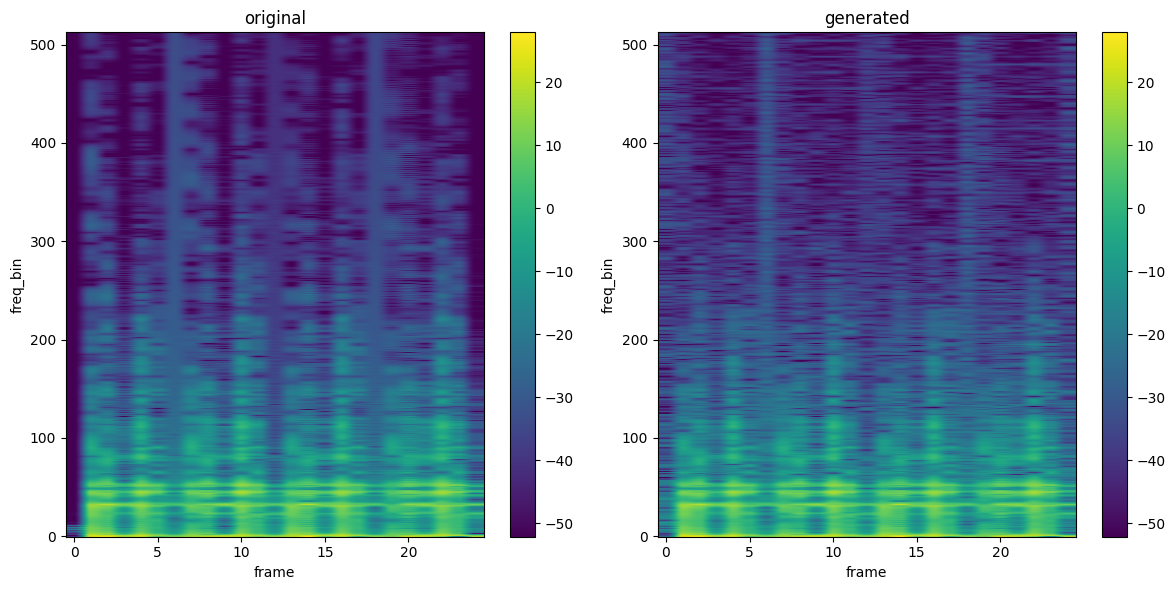

In [ ]:
n_fft = 1024
win_length = None
hop_length = 512

# define transformation
spectrogram = torchaudio.transforms.Spectrogram(
    n_fft=n_fft,
    win_length=win_length,
    hop_length=hop_length,
    center=True,
    pad_mode="reflect",
    power=2.0,
)
# Perform transformation
happy_waveform = torch.tensor(original_audio_signal).reshape(1,-1)
sad_waveform = torch.tensor(generated_audio_signal).reshape(1,-1)
happy_spec = spectrogram(happy_waveform)
sad_spec = spectrogram(sad_waveform)

plot_2spectrograms(happy_spec[0], sad_spec[0], title1='original',title2='generated', filename="spectrogram_plots.png")



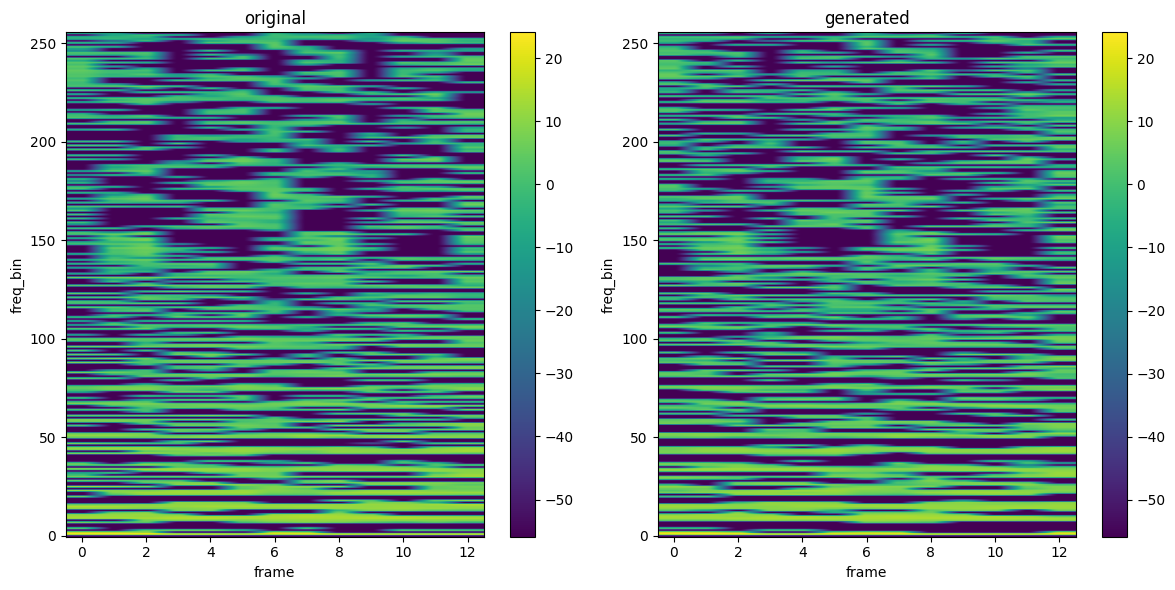

In [ ]:
n_fft = 2048
win_length = None
hop_length = 512
n_mels = 256
n_mfcc = 256

orig_waveform, orig_sample_rate = torchaudio.load("original_audio_output.wav", normalize=True)
gen_waveform, gen_sample_rate = torchaudio.load("generated_audio_output.wav", normalize=True)
mfcc_transform = torchaudio.transforms.MFCC(
    sample_rate=11000,
    n_mfcc=n_mfcc,
    melkwargs={
      'n_fft': n_fft,
      'n_mels': n_mels,
      'hop_length': hop_length,
      'mel_scale': 'htk',
    }
)

mfcc1 = mfcc_transform(orig_waveform)
mfcc2 = mfcc_transform(gen_waveform)
plot_2spectrograms(mfcc1[0], mfcc2[0],title1='original',title2='generated',filename="mfcc_plots.png")

In [ ]:
orig_sample_audio = X_train[0]

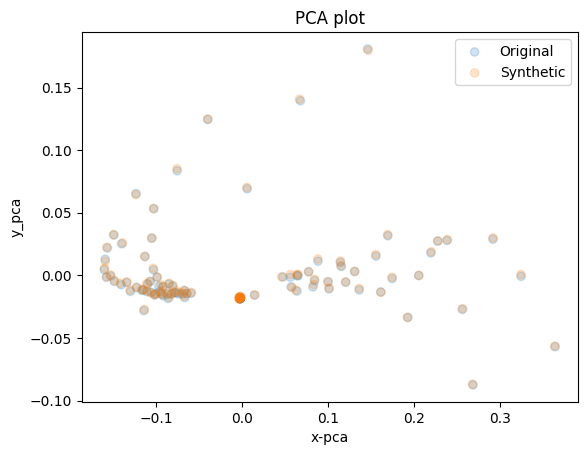

In [ ]:
visualization(orig_sample_audio, sample_audio.T, "pca")

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 200 samples in 0.000s...
[t-SNE] Computed neighbors for 200 samples in 0.228s...
[t-SNE] Computed conditional probabilities for sample 200 / 200
[t-SNE] Mean sigma: 0.031177
[t-SNE] KL divergence after 250 iterations with early exaggeration: 41.155243
[t-SNE] KL divergence after 300 iterations: 0.118497


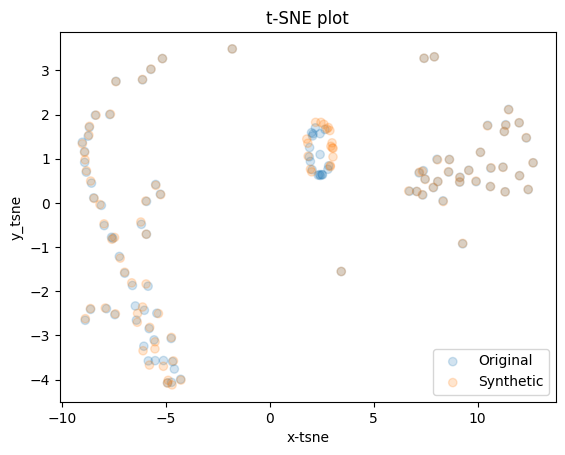

In [ ]:
visualization(orig_sample_audio, sample_audio.T, "tsne")